# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.239446
Ticket      0.169013
Name        0.136668
Fare        0.135763
Age         0.110130
Cabin       0.066970
Pclass      0.060529
SibSp       0.032174
Parch       0.030144
Embarked    0.019162
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [21]:
# 取出前五大重要特徵的Columns
list(feats[:9].index)

['Sex', 'Ticket', 'Name', 'Fare', 'Age', 'Cabin', 'Pclass', 'SibSp', 'Parch']

In [59]:
# 高重要性特徵 + 隨機森林
# 將前五大特徵的Columns做MinMaxScaler，再用隨機森林隊訓練資料做訓練，並計算分數
high_feature = list(feats[:7].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()
# 分數高於原始特徵的分數

0.832803967108154

In [60]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8294206264515724

* list(feats[:7].index) 取前6個特徵的分數都會低於原始特徵，但取第七個重複計算多次時，分數又會亂跳動？WHY?
* 有時高於原始特徵，有時又低於...不懂
* 又回去看一次課程內容，所以用特徵重要性做完特徵增減、訓練後，需要交叉驗證結果是否有改善，沒有就要回去上一步

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

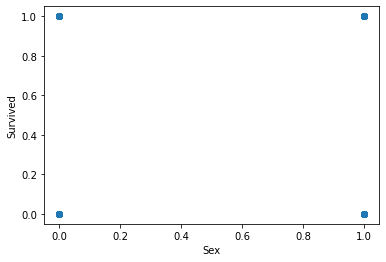

In [61]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['Sex'], y=train_Y, fit_reg=False)
plt.show()

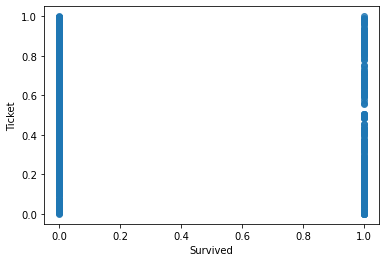

In [62]:
# 第二名       
sns.regplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()

In [63]:
# 製作新特徵看效果
df['Add_char'] = (df['Sex'] + df['Ticket']) / 2
df['Multi_char'] = df['Sex'] * df['Ticket']
df['GO_div1p'] = df['Sex'] / (df['Ticket']+1) * 2
df['OG_div1p'] = df['Sex'] / (df['Ticket']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8350323269097985

* 唉唷！分數變高了，提升了預測能力，不錯。

In [64]:
# 上面做的是新增後面4個新的Columns，由第一、第二名特徵重要性的兩個Cloumns組合而成
df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Add_char,Multi_char,GO_div1p,OG_div1p
0,1.0,0.121348,1.0,0.283951,0.125,0.000000,0.769118,0.014151,0.000000,1.000000,0.884559,0.769118,1.130507,1.130507
1,0.0,0.213483,0.0,0.481481,0.125,0.000000,0.876471,0.139136,0.557823,0.333333,0.438235,0.000000,0.000000,0.000000
2,1.0,0.396629,0.0,0.333333,0.000,0.000000,0.983824,0.015469,0.000000,1.000000,0.491912,0.000000,0.000000,0.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.000000,0.072059,0.103644,0.380952,1.000000,0.036029,0.000000,0.000000,0.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.000000,0.694118,0.015713,0.000000,1.000000,0.847059,0.694118,1.180556,1.180556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.5,0.615730,1.0,0.345679,0.000,0.000000,0.148529,0.025374,0.000000,1.000000,0.574265,0.148529,1.741357,1.741357
887,0.0,0.340449,0.0,0.246914,0.000,0.000000,0.020588,0.058556,0.210884,1.000000,0.010294,0.000000,0.000000,0.000000
888,1.0,0.464045,0.0,0.000000,0.125,0.333333,0.992647,0.045771,0.000000,1.000000,0.496324,0.000000,0.000000,0.000000
889,0.0,0.091011,1.0,0.333333,0.000,0.000000,0.011765,0.058556,0.414966,0.333333,0.505882,0.011765,1.976744,1.976744
